In [267]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [268]:
bat_dict = pickle.load(open(r'./Data/bat_dict.pkl', 'rb'))

In [269]:
all_bat_data = []
q_nominal = 1.1

for battery_id, data in bat_dict.items():
    summary = data["summary"]

    cycles = np.array(summary["cycle"][1:])
    q_discharge = np.array(summary["QD"][1:])
    ir = np.array(summary["IR"][1:])
    t_avg = np.array(summary["Tavg"][1:])
    t_min = np.array(summary["Tmin"][1:])
    t_max = np.array(summary["Tmax"][1:])
    charge_time = np.array(summary["chargetime"][1:])
    
    soh = (q_discharge/q_nominal)

    battery_df = pd.DataFrame({
        'battery_id': battery_id,
        'cycle': cycles,
        'soh': soh,
        'IR': ir,
        'Tavg': t_avg,
        'Tmin': t_min,
        'Tmax': t_max,
        'charge_time': charge_time
    })

    all_bat_data.append(battery_df)

full_df = pd.concat(all_bat_data, ignore_index=True)
full_df = full_df.sort_values(by=["battery_id", "cycle"]).reset_index(drop=True)

In [270]:
del bat_dict

In [271]:
full_df.head()

,battery_id,cycle,soh,IR,Tavg,Tmin,Tmax,charge_time
0,b1c0,2.0,0.973354,0.016742,31.875011,29.566130,35.652016,13.341250
1,b1c0,3.0,0.974455,0.016724,31.931490,29.604385,35.692978,13.425777
2,b1c0,4.0,0.975009,0.016681,31.932603,29.744202,35.680588,13.425167
3,b1c0,5.0,0.975613,0.016662,31.959322,29.644709,35.728691,13.341442
4,b1c0,6.0,0.975978,0.016623,31.961062,29.752932,35.711758,13.340835


In [272]:
full_df["soh_target"] = full_df.groupby("battery_id")["soh"].shift(-1)

for lag in [1,2,3]:
    full_df[f"soh_lag_{lag}"] = full_df.groupby("battery_id")["soh"].shift(lag)

full_df["IR_lag_1"] = full_df.groupby("battery_id")["IR"].shift(1)
#full_df["Tavg_lag_1"] = full_df.groupby("battery_id")["Tavg"].shift(1)

full_df["soh_diff_1"] = full_df["soh"] - full_df["soh_lag_1"]
full_df["IR_diff_1"] = full_df["IR"] - full_df["IR_lag_1"]

In [273]:
num_rows = len(full_df)
full_df.dropna(inplace=True)
print(num_rows - len(full_df))

336


In [274]:
full_df.head()

,battery_id,cycle,soh,IR,Tavg,Tmin,Tmax,charge_time,soh_target,soh_lag_1,soh_lag_2,soh_lag_3,IR_lag_1,soh_diff_1,IR_diff_1
3,b1c0,5.0,0.975613,0.016662,31.959322,29.644709,35.728691,13.341442,0.975978,0.975009,0.974455,0.973354,0.016681,0.000604,-0.000019
4,b1c0,6.0,0.975978,0.016623,31.961062,29.752932,35.711758,13.340835,0.976356,0.975613,0.975009,0.974455,0.016662,0.000366,-0.000038
5,b1c0,7.0,0.976356,0.016600,31.900562,29.564377,35.615650,13.340198,0.976704,0.975978,0.975613,0.975009,0.016623,0.000378,-0.000024
6,b1c0,8.0,0.976704,0.016577,31.921668,29.628630,35.546783,13.425442,0.976811,0.976356,0.975978,0.975613,0.016600,0.000348,-0.000023
7,b1c0,9.0,0.976811,0.016588,31.870082,29.597345,35.539406,13.425190,0.976852,0.976704,0.976356,0.975978,0.016577,0.000107,0.000011


In [275]:
features = [
    "cycle",
    "soh",
    "IR",
    "Tavg",
    "Tmax",
    "charge_time",
    "soh_lag_1",
    "soh_lag_2",
    "soh_lag_3",
    "soh_diff_1",
    "IR_diff_1"
]

X = full_df[features]
y = full_df["soh_target"]

In [276]:
all_batteries = full_df["battery_id"].unique()

test_ids = np.random.choice(all_batteries, size=int(0.25 * len(all_batteries)), replace=False)
print(test_ids)

['b1c29' 'b1c37' 'b1c34' 'b2c33' 'b1c4' 'b2c19' 'b1c45' 'b1c30' 'b1c31'
 'b2c24' 'b2c43' 'b2c0' 'b2c6' 'b1c38' 'b1c9' 'b2c17' 'b1c2' 'b2c36'
 'b1c21' 'b1c32' 'b2c47']


In [277]:
train_ids = full_df[~full_df["battery_id"].isin(test_ids)].index
test_ids = full_df[full_df["battery_id"].isin(test_ids)].index

X_train = X.loc[train_ids]
y_train = y.loc[train_ids]

X_test = X.loc[test_ids]
y_test = y.loc[test_ids]

test_df = full_df.loc[test_ids, ["battery_id", "cycle", "soh", "soh_target"]].copy()

In [278]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(42813, 11) (42813,) (16028, 11) (16028,)


In [279]:
rf_model = RandomForestRegressor(n_estimators=100, n_jobs=-1, max_features="sqrt", min_samples_split=5, min_samples_leaf=2, oob_score=True, random_state=131)

In [280]:
rf_model.fit(X_train, y_train)
print(rf_model.oob_score_)

0.9700285848074719


In [281]:
y_pred_test = rf_model.predict(X_test)
test_df["soh_pred"] = y_pred_test

test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_mae = mean_absolute_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)

print(test_rmse, test_mae, test_r2)

0.0024910342556496105 0.0006503672224296347 0.9976176718218271


In [282]:
importances = rf_model.feature_importances_

feature_importances = pd.DataFrame({
    "feature": features,
    "importance": importances
})

feature_importances.sort_values(by="importance", ascending=False)

,feature,importance
6,soh_lag_1,0.239379
7,soh_lag_2,0.227965
1,soh,0.209299
8,soh_lag_3,0.190474
2,IR,0.061514
5,charge_time,0.039403
9,soh_diff_1,0.019837
0,cycle,0.009116
3,Tavg,0.001406
4,Tmax,0.001401


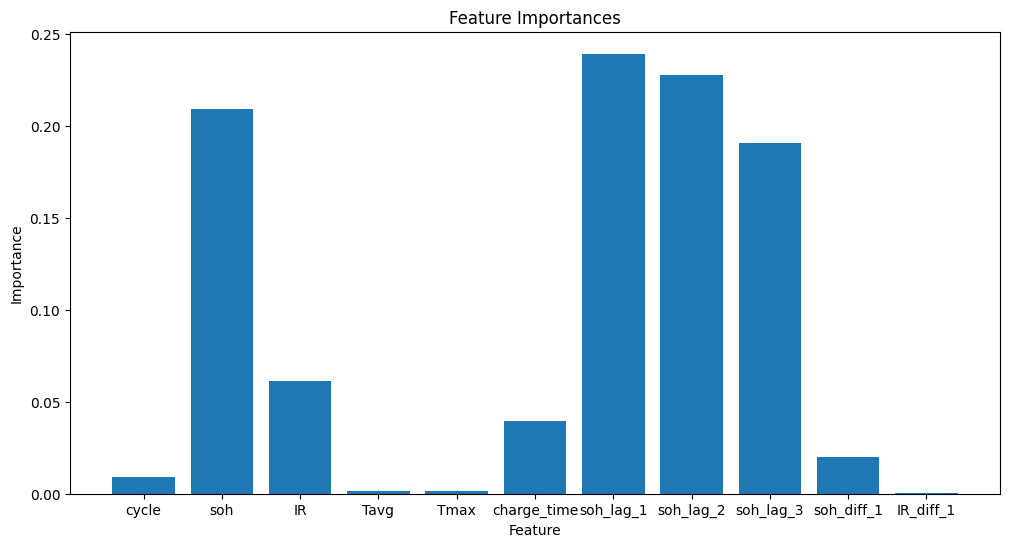

In [283]:
plt.figure(figsize=(12,6))
plt.bar(feature_importances["feature"], feature_importances["importance"])
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importances")
plt.show()

In [284]:
features = [
    "soh",
    "IR",
    "charge_time",
    "soh_lag_1",
    "soh_lag_2",
    "soh_lag_3"
]

X = full_df[features]
y = full_df["soh_target"]

X_train = X.loc[train_ids]
y_train = y.loc[train_ids]

X_test = X.loc[test_ids]
y_test = y.loc[test_ids]

test_df = full_df.loc[test_ids, ["battery_id", "cycle", "soh", "soh_target"]].copy()

rf_model = RandomForestRegressor(n_estimators=100, n_jobs=-1, max_features="sqrt", min_samples_split=5, min_samples_leaf=2, oob_score=True, random_state=131)
rf_model.fit(X_train, y_train)
print(rf_model.oob_score_)

0.9702339802359933


In [285]:
y_pred_test = rf_model.predict(X_test)
test_df["soh_pred"] = y_pred_test

test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_mae = mean_absolute_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)

print(test_rmse, test_mae, test_r2)

0.0017947320034816022 0.0004122406212550971 0.9987633653749212


In [286]:
importances = rf_model.feature_importances_

feature_importances = pd.DataFrame({
    "feature": features,
    "importance": importances
})

feature_importances.sort_values(by="importance", ascending=False)

,feature,importance
0,soh,0.293283
4,soh_lag_2,0.239895
3,soh_lag_1,0.230697
5,soh_lag_3,0.201539
2,charge_time,0.024367
1,IR,0.010219
